In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_balanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced.reset_index(drop=True, inplace=True)

print(df_balanced.describe())

print(df_balanced['region'].value_counts())

            region    education      jobtype       cptype        sales  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      1.000000     0.890000     0.506667     0.865000     1.202531   
std       0.816837     1.195446     0.500164     0.824019     2.893149   
min       0.000000     0.000000     0.000000     0.000000    -0.130200   
25%       0.000000     0.000000     0.000000     0.000000    -0.124425   
50%       1.000000     0.000000     1.000000     1.000000     0.021300   
75%       2.000000     2.000000     1.000000     2.000000     0.647700   
max       2.000000     4.000000     1.000000     2.000000    11.593808   

         employees   aversalary      capital  pros_encoded  
count  1200.000000  1200.000000  1200.000000   1200.000000  
mean      1.108672     0.255039     1.281019      0.370583  
std       2.392501     0.782717     3.209620      0.604012  
min      -0.208500    -1.782600    -0.113000     -0.500000  
25%      -0.157775    -0.173

### 수집된 데이터 분포 단순 시각화

튜닝된 xgboostClassifier 모델에서 피쳐 중요도 상위 3개 피쳐 ['pros_encoded', 'aversalary', 'capital'] 를 가지고 데이터 분포 시각화  
결측값은 모두 drop, 각 클래스별 행데이터 갯수는 400 개로 통일.  

해당 방법으로는 지역에 따른 분포가 달라보이지는 않는다.  

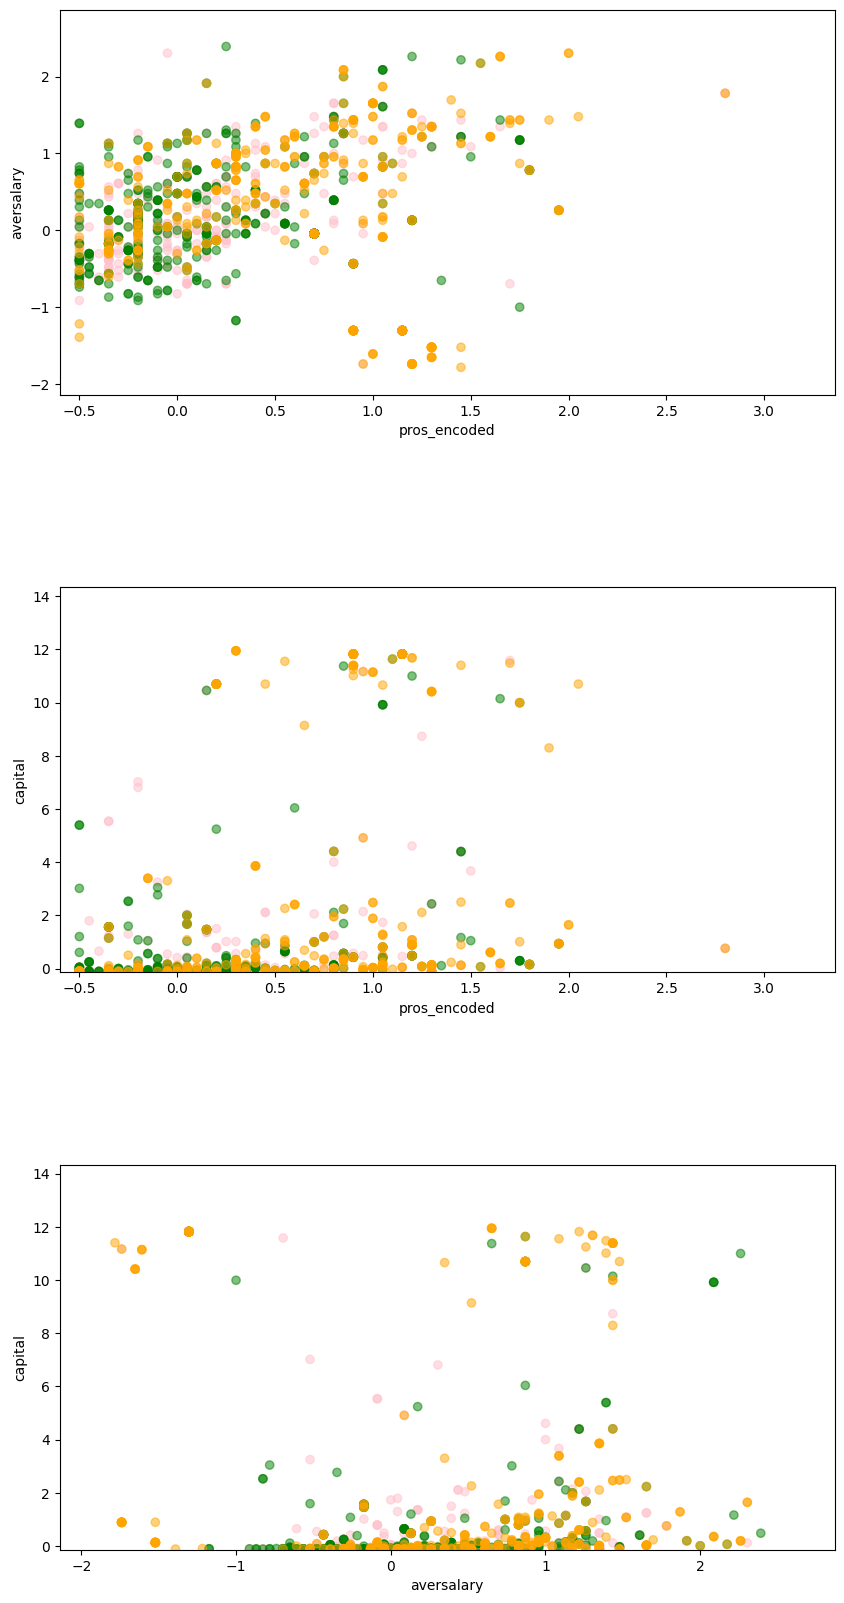

In [75]:
numClusters = 3
# 수도권 : 서울, 인천, 세종, 경기 -> 2
# 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산 -> 1
# 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주 -> 0
regionColors = ['pink', 'green', 'orange']
dataPointColor = [regionColors[row] for row in df_balanced['region']]

features = ['pros_encoded', 'aversalary', 'capital']

# math.comb(len(features),2)
fig, axes = plt.subplots(3, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)

tmp_idx = 0
for i in range(len(features)):
    for j in range(i+1, len(features)):
        ax = axes[tmp_idx]
        ax.scatter(df_balanced[features[i]], df_balanced[features[j]], c=dataPointColor, alpha=0.5)
        
        x_min = df_balanced[features[i]].min()
        x_max = df_balanced[features[i]].max()
        y_min = df_balanced[features[j]].min()
        y_max = df_balanced[features[j]].max()

        ax.set_xlim(x_min * 1.2 , x_max * 1.2)
        ax.set_ylim(y_min * 1.2, y_max * 1.2)

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        tmp_idx += 1

plt.show()

### 단순 시각화 - 지역별 구인공고를 내건 기업의 규모 (중소(0), 중견(1), 대기업(1)) 비율

cptype
0    0.58
1    0.23
2    0.19
Name: count, dtype: float64
cptype
0    0.65
1    0.18
2    0.18
Name: count, dtype: float64
cptype
0    0.38
2    0.35
1    0.27
Name: count, dtype: float64


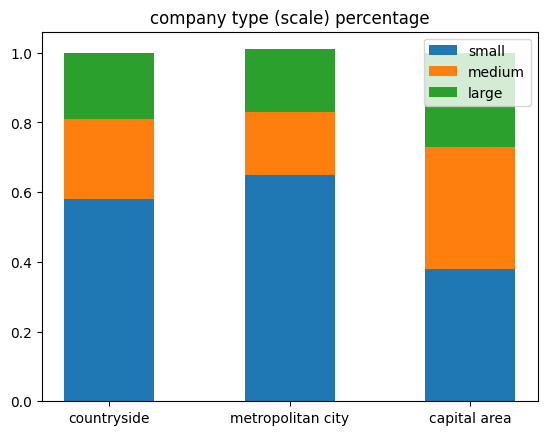

In [109]:
region_0 = df[df['region'] == 0]
region_1 = df[df['region'] == 1]
region_2 = df[df['region'] == 2]

region_0_total = region_0.shape[0]
region_1_total = region_1.shape[0]
region_2_total = region_2.shape[0]

region_0_percentages = np.round(region_0['cptype'].value_counts() / region_0_total, 2)
region_1_percentages = np.round(region_1['cptype'].value_counts() / region_1_total, 2)
region_2_percentages = np.round(region_2['cptype'].value_counts() / region_2_total, 2)

print(region_0_percentages)
print(region_1_percentages)
print(region_2_percentages)


regions = (
    'countryside',
    'metropolitan city',
    'capital area',
)

x = pd.DataFrame({'0' : region_0_percentages.values,
              '1': region_1_percentages.values,
              '2': region_2_percentages.values,
              })


weight_counts = {
    "small": x.iloc[0].values,
    "medium": x.iloc[1].values,
    "large": x.iloc[2].values,
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(regions, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("company type (scale) percentage")
ax.legend(loc="upper right")

plt.show()

## k-means clustering

the number of clusters is 3  

2D visualization with PCA

수도권 : 서울, 인천, 세종, 경기 -> 2  
수도권 외 광역시: 부산, 대구, 광주, 대전, 울산 -> 1  
그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주 -> 0  

지역과는 무관하게    
대부분의 데이터가 속하는 그룹, 아웃라이어 끼리 묶인 그룹, 두 그룹 사이 어딘가에 무작위로 퍼진 그룹으로 분류되었다.  
대부분의 데이터가 속하는 그룹을 제외한 데이터포인터는 노이즈, 혹은 아웃라이어 수준으로 판단된다.

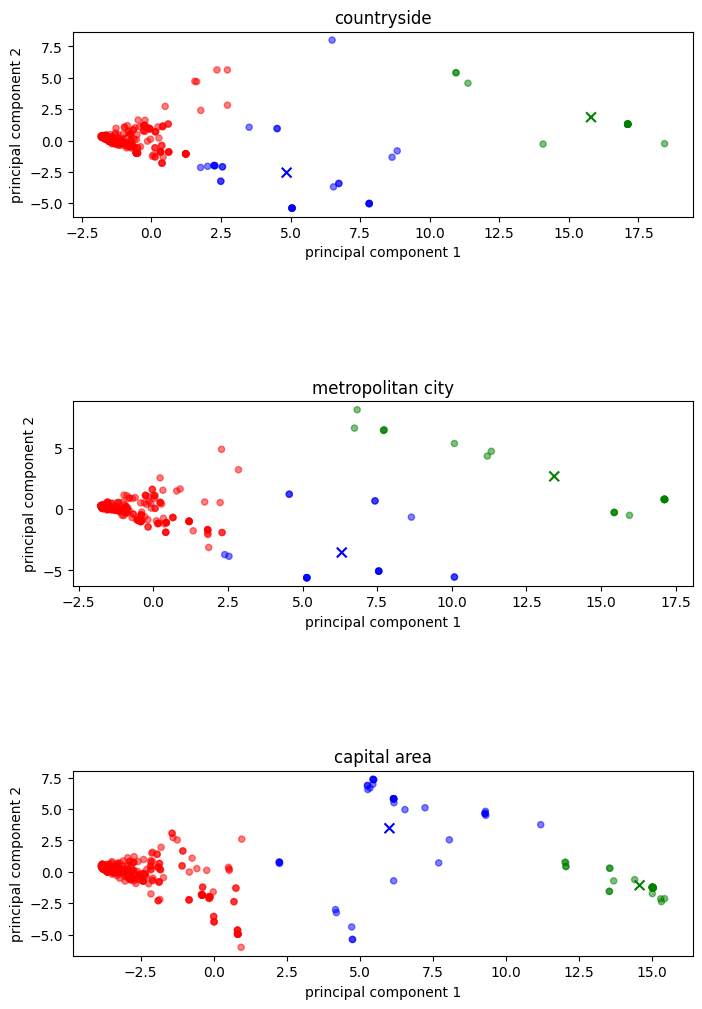

In [126]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced[df_balanced["region"] == regionType]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca2)
    labels = kmeans.predict(X_pca2)
    dataPointColor = [colors[row] for row in labels]

    centroids = kmeans.cluster_centers_
    centroidColor = [colors[item] for item in range(numClusters)]

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=dataPointColor,
        s=20,
        alpha=0.5,
    )

    # centroids
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        c=centroidColor,
        s=50,
        marker="x",
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

plt.show()


### PCA 로 주성분 3개를 갖고 Kmeans 클러스터링 수행  
의미있는 결과는 없었다.

d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


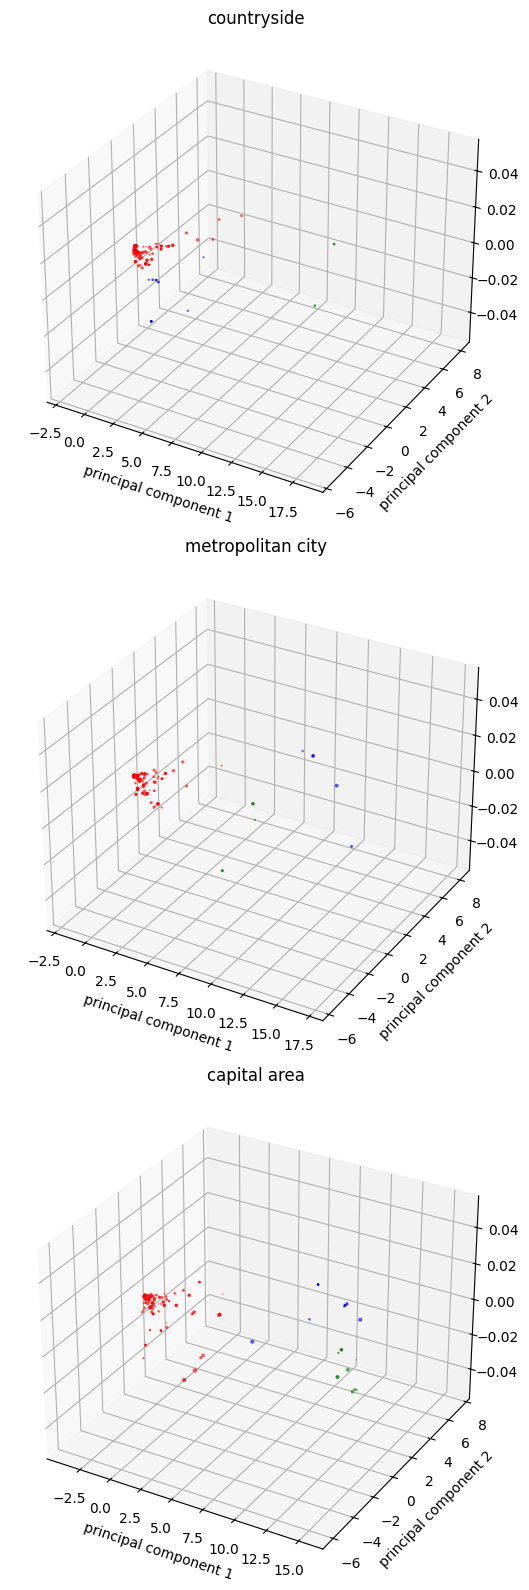

In [173]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # num : 0..2
    X = df_balanced[df_balanced["region"] == regionType]

    pca = PCA(n_components=3)
    pca_fit = pca.fit(X.values)
    X_pca3 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca3,
        columns=[
            "p_component 1",
            "p_component 2",
            "p_component 3",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca3)
    labels = kmeans.predict(X_pca3)
    dataPointColor = [colors[row] for row in labels]

    ax = fig.add_subplot(3, 1, regionType + 1, projection="3d")

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        principalDf["p_component 3"],
        c=dataPointColor,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")
    # ax.set_zlabel("principal component 3")

plt.tight_layout()
plt.show()


## DBSCAN  
사전에 클러스터 갯수를 지정하지 않고 클러스터링을 수행하기 위해 DBSCAN 사용.  

Kmeans 클러스터링 결과까지 함께 고려해봐도,  
#### '지역마다 세 개의 클러스터로 분류되는 경향이 있을 것이다'라는 가설은 틀린 것으로 보인다.  

{0, 1, -1}
The number of clusters (countryside):  2
{0, -1}
The number of clusters (metropolitan city):  1
{0, 1, 2, 3, -1}
The number of clusters (capital area):  4


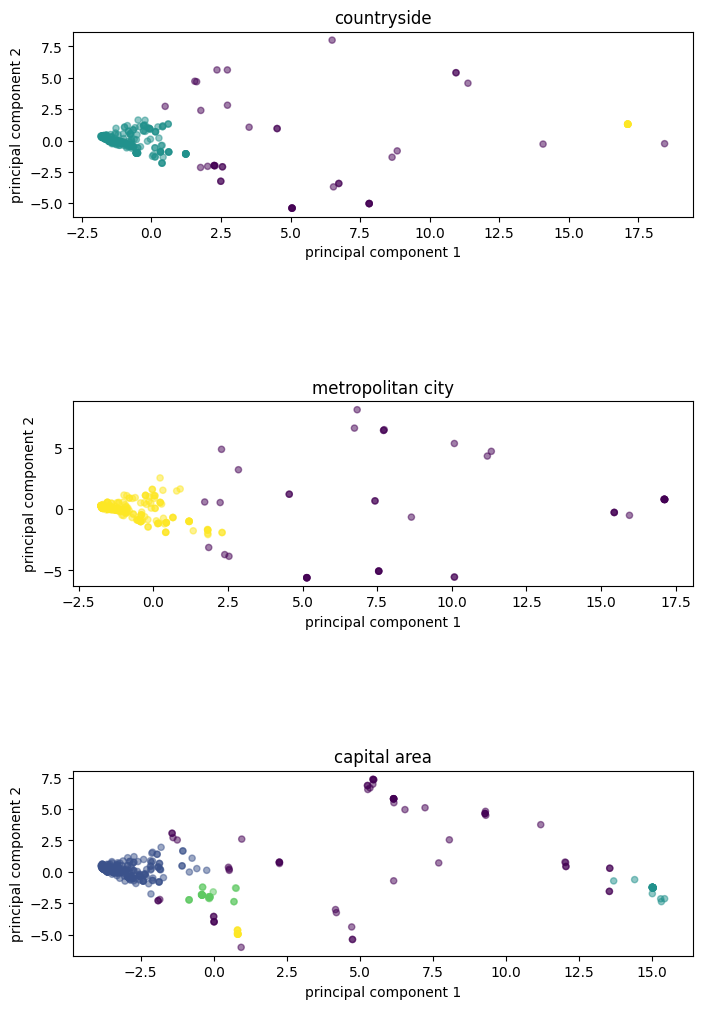

In [181]:
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced[df_balanced["region"] == regionType]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    predict = DBSCAN(eps=1, min_samples=10).fit_predict(X_pca2)

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=predict,
        s=20,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

    # predict 결과가 -1 인 경우도 존재 (미분류)
    print(set(predict))
    print(f"The number of clusters ({regionTypes[regionType]}): ", len(set(predict)) - 1)

plt.show()